In [ ]:
#install dependencies 
#pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
#pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#pip install torch-geometric
#pip install open3d
#pip install pandas
#pip install nibabel
#pip install pyvista
#pip install scikit-image

In [10]:
from pathlib import Path
import glob
import os
import numpy as np
import pandas as pd
from tqdm import tqdm 
import torch
import open3d as o3d

print(torch.__version__)

1.12.1+cu113


In [93]:
path = "C:/Users/aorhu/Masaüstü/ADLM/repo/BodyMeshGNN/1119738/body_surface_mesh.pt"

In [94]:
data_sample = torch.load(path)

In [95]:
data_sample.edge_index

tensor([[     2,      4,      0,  ..., 248088, 248047, 248088],
        [     1,      3,      3,  ..., 248087, 248040, 248042]])

In [ ]:
data_sample.eid

In [ ]:
# with open3d: point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(data_sample.x))

o3d.visualization.draw_geometries([pcd])

In [ ]:
# with open3d: triangle mesh 
mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.asarray(verts)),
                                 triangles=o3d.utility.Vector3iVector(np.asarray(faces)))

mesh.compute_vertex_normals()
mesh.compute_convex_hull()
o3d.visualization.draw_geometries([mesh],mesh_show_back_face=True,mesh_show_wireframe=True)


In [ ]:
# with open3d: graph
lines = o3d.utility.Vector2iVector(np.asarray(data_sample.edge_index.T))
line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np.asarray(data_sample.x)),
        lines=lines)

line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for i in range(len(lines))])

o3d.visualization.draw_geometries([line_set])

In [ ]:
# reading ID mapping
id_map_path = "C:/Users/aorhu/Masaüstü/ADLM/Bridge_eids_60520_87802.csv"

In [ ]:
id_map = pd.read_csv(id_map_path)

In [ ]:
id_map

In [ ]:
# reading basic_features

In [ ]:
basic_features_path = "C:/Users/aorhu/Masaüstü/ADLM/basic_features.csv"

In [ ]:
basic_features = pd.read_csv(basic_features_path)

In [ ]:
basic_features

In [ ]:
#reading file directories for patients into dictionary

In [2]:
DATA_ROOT = Path("D:/ADLM Data/body_meshes/")

map_dict = {}

In [ ]:
for file in os.listdir(str(DATA_ROOT)):
    _path = os.path.join(str(DATA_ROOT), file).replace('\\', '/')

    sex = "female" if int(basic_features["31-0.0"][basic_features.index[basic_features['eid'] == int(file)]]) == 0 else "male"
    
    map_dict[file] = dict({'path': str(_path) +'/body_surface_mesh.pt',
                           'old_id': int(id_map["eid_60520"][id_map.index[id_map['eid_87802'] == int(file)]]),
                           'sex': sex})

In [11]:
for file in tqdm(os.listdir(str(DATA_ROOT))):
    _path = os.path.join(str(DATA_ROOT), file).replace('\\', '/')


100%|██████████████████████████████████████████████████████████████████████████| 9291/9291 [00:00<00:00, 444986.85it/s]


In [97]:
map_dict

{'1000071': {'path': 'D:/ADLM Data/body_meshes/1000071/body_surface_mesh.pt',
  'old_id': 2119543,
  'sex': 'female'},
 '1000109': {'path': 'D:/ADLM Data/body_meshes/1000109/body_surface_mesh.pt',
  'old_id': 1018162,
  'sex': 'female'},
 '1000125': {'path': 'D:/ADLM Data/body_meshes/1000125/body_surface_mesh.pt',
  'old_id': 5950933,
  'sex': 'male'},
 '1000180': {'path': 'D:/ADLM Data/body_meshes/1000180/body_surface_mesh.pt',
  'old_id': 3624064,
  'sex': 'male'},
 '1000191': {'path': 'D:/ADLM Data/body_meshes/1000191/body_surface_mesh.pt',
  'old_id': 3092647,
  'sex': 'male'},
 '1000352': {'path': 'D:/ADLM Data/body_meshes/1000352/body_surface_mesh.pt',
  'old_id': 5806236,
  'sex': 'male'},
 '1000456': {'path': 'D:/ADLM Data/body_meshes/1000456/body_surface_mesh.pt',
  'old_id': 3829892,
  'sex': 'male'},
 '1000721': {'path': 'D:/ADLM Data/body_meshes/1000721/body_surface_mesh.pt',
  'old_id': 3284899,
  'sex': 'male'},
 '1000770': {'path': 'D:/ADLM Data/body_meshes/1000770/body_

In [96]:
len(map_dict)

9291

In [91]:
def edge_visualize(_index, _dict):
    
    sample = torch.load(_dict[_index]["path"])
    
    lines = o3d.utility.Vector2iVector(np.asarray(sample.edge_index.T))
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np.asarray(sample.x)),
        lines=lines)

    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for i in range(len(lines))])

    o3d.visualization.draw_geometries([line_set])
    
def point_cloud_visualize(_index, _dict):
    
    sample = torch.load(_dict[_index]["path"])
    
    pcd = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(np.asarray(sample.x)))

    o3d.visualization.draw_geometries([pcd])

In [92]:
edge_visualize("1009499", map_dict)

In [15]:
path = "C:/Users/aorhu/Masaüstü/1000071/spleen_mesh.pt"
sample = torch.load(path)

In [16]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(sample.x))

o3d.visualization.draw_geometries([pcd])

In [17]:
lines = o3d.utility.Vector2iVector(np.asarray(sample.edge_index.T))
line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np.asarray(sample.x)),
        lines=lines)

line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for i in range(len(lines))])

o3d.visualization.draw_geometries([line_set])

# Mesh Visualization from Segmentation Data

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pyvista
from skimage.measure import marching_cubes
import numpy as np

In [4]:
def pad_edge_list(edges):
    padding = np.ones(edges.shape[0], int)*3
    edges_w_padding = np.vstack((padding, edges.T)).T
    return edges_w_padding

In [5]:
path = "C:/Users/aorhu/Masaüstü/body_mask.nii.gz"

In [6]:
body_segment = nib.load(path)
body_segment_data = body_segment.get_fdata()

In [7]:
verts, faces, norms, vals = marching_cubes(body_segment_data, level=0, step_size=1)

In [8]:
verts = verts/np.array(body_segment_data.shape) 

In [9]:
verts

array([[0.00446429, 0.35119048, 0.75757576],
       [0.00892857, 0.35119048, 0.75482094],
       [0.00892857, 0.3452381 , 0.75757576],
       ...,
       [0.99553571, 0.4047619 , 0.88980716],
       [0.99553571, 0.41071429, 0.88429752],
       [0.99553571, 0.41666667, 0.88429752]])

In [10]:
edges = np.concatenate((faces[:,:2], faces[:,1:]), axis=0)

In [1]:
len(faces)

NameError: name 'faces' is not defined

C:\Users\aorhu\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


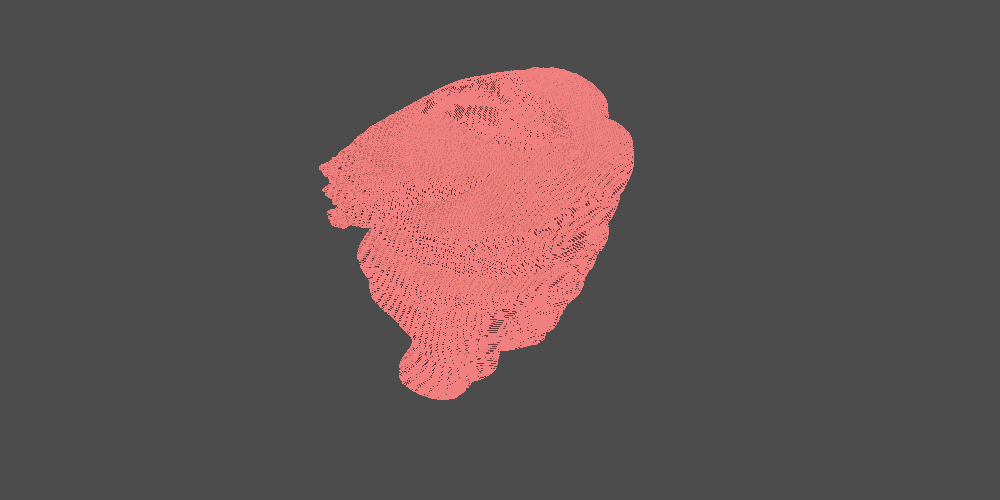

In [15]:
pyvista.set_plot_theme("default")
plotter = pyvista.Plotter(shape=(1, 1), window_size=[1000, 500], border=False)
#plotter = pyvista.Plotter(notebook=False)

plotter.subplot(0, 0)
lines = np.concatenate((np.int32(2*np.ones((edges.shape[0],1))), edges), 1)
mesh = pyvista.PolyData(verts, pad_edge_list(faces))
mesh.lines = lines.flatten()
plotter.add_mesh(mesh, render_points_as_spheres=False, color="lightcoral", show_edges=True, line_width=1, edge_color='mediumorchid', point_size=2, )
plotter.show()

In [12]:
mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.asarray(verts)),
                                 triangles=o3d.utility.Vector3iVector(np.asarray(faces)))

mesh.compute_vertex_normals()
mesh.compute_convex_hull()
o3d.visualization.draw_geometries([mesh],mesh_show_back_face=True,mesh_show_wireframe=False)
